In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import time
import pandas as pd
from sklearn import *

from itertools import product
import os

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [0]:
from google.colab import auth
auth.authenticate_user()

In [4]:

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#'''

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

In [10]:
!mkdir -p my_drive
!google-drive-ocamlfuse my_drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [4]:
#base = ''
#data = 'data'+os.sep
seed = np.random.seed(7)

In [5]:
# load data
x_data_all = pd.read_csv('data/X_train.txt')
y_data_all = pd.read_csv('data/Y_train.txt')
x_test = pd.read_csv('data/X_test.txt')

In [6]:
x_data_all.columns

Index(['age', 'workclass', 'education', 'education.num', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'capital.gain',
       'capital.loss', 'hours.per.week', 'native.country'],
      dtype='object')

In [7]:
def convert(X_train):
    y = X_train.multiply(-1, axis=10)
    X_train.drop_duplicates()
#    X_train['capital.loss'] = y['capital.loss']
#    X_train['education.num'] = X_train['education.num'].astype('category')
    X = pd.get_dummies(X_train[X_train.columns],drop_first=True)
    return X

In [8]:
x_data = convert(x_data_all)
x_test = convert(x_test)
y_data = y_data_all

In [9]:
# split training / validation data
x_train, x_validation, y_train, y_validation = model_selection.train_test_split(
    x_data, y_data, test_size=0.2, random_state=seed)

In [10]:
rocs_arr = []

In [46]:
logistic_classifier = pipeline.Pipeline([
    ('poly', preprocessing.PolynomialFeatures(degree=2, interaction_only=False)),
    ('logistic', linear_model.LogisticRegression(solver='newton-cg'))])

print("training started")
starting_time = time.time()
logistic_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

logistic_classifier_roc = metrics.roc_auc_score(y_validation, logistic_classifier.predict_proba(x_validation)[:,1])
rocs_arr.append((logistic_classifier_roc,'logistic'))
print("validation roc:", logistic_classifier_roc)

print("training error:", 1 - logistic_classifier.score(x_train, y_train))
print("validation error:", 1 - logistic_classifier.score(x_validation, y_validation))

training started
training finished
validation roc: 0.8955869999999999
training error: 0.142625
validation error: 0.15349999999999997


In [47]:
knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=20,metric= 'manhattan',weights='uniform', n_jobs=-1)

print("training started")
starting_time = time.time()
knn_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

y_validation_hat = knn_classifier.predict_proba(x_validation)[:,1]

knn_classifier_roc = metrics.roc_auc_score(y_validation, y_validation_hat)
rocs_arr.append((knn_classifier_roc,'knn'))
print(knn_classifier_roc)

print("training error:", 1 - knn_classifier.score(x_train, y_train))
print("validation error:", 1 - knn_classifier.score(x_validation, y_validation))

training started
training finished, took 0.47425222396850586 seconds
0.8994308333333333
training error: 0.1354375
validation error: 0.15700000000000003


In [48]:
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    }
#svm_classifier = model_selection.GridSearchCV(svm.SVC(kernel='rbf',probability=True), param_grid, cv=10,verbose=2)

svm_classifier = svm.SVC(kernel='rbf',probability=True)
print("training started")
starting_time = time.time()
svm_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

y_validation_hat = svm_classifier.predict_proba(x_validation)[:,1]

svm_classifier_roc = metrics.roc_auc_score(y_validation, y_validation_hat)
rocs_arr.append((svm_classifier_roc,'svm'))
print(svm_classifier_roc)

print("training error:", 1 - svm_classifier.score(x_train, y_train))
print("validation error:", 1 - svm_classifier.score(x_validation, y_validation))

training started
training finished, took 246.38654565811157 seconds
0.8867236666666667
training error: 0.13143749999999998
validation error: 0.14525


In [49]:
params = {'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100,
 'oob_score': True
}
random_forest_classifier = ensemble.RandomForestClassifier(**params)

print("training started")
starting_time = time.time()
random_forest_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

random_forest_classifier_roc = metrics.roc_auc_score(
    y_validation, random_forest_classifier.predict_proba(x_validation)[:,1])
print(random_forest_classifier_roc)
rocs_arr.append((random_forest_classifier_roc,'rf'))

print("training error:", 1 - random_forest_classifier.score(x_train, y_train))
print("validation error:", 1 - random_forest_classifier.score(x_validation, y_validation))

training started
training finished, took 2.270195484161377 seconds
0.9134686666666667
training error: 0.10375000000000001
validation error: 0.14449999999999996


In [50]:
neural_network_classifier = pipeline.Pipeline([
    ("scale", preprocessing.StandardScaler().fit(x_train)),
    ("nn", neural_network.MLPClassifier(
        hidden_layer_sizes=(14*20, 14*10),
        warm_start=True))])

print("training started")
starting_time = time.time()
neural_network_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

neural_network_classifier_roc = metrics.roc_auc_score(
    y_validation, neural_network_classifier.predict_proba(x_validation)[:,1])
rocs_arr.append((neural_network_classifier,'nn'))
print("validation roc:", neural_network_classifier_roc)
print("training error:", 1 - neural_network_classifier.score(x_train, y_train))
print("validation error:", 1 - neural_network_classifier.score(x_validation, y_validation))

training started
training finished, took 53.11860394477844 seconds
validation roc: 0.8771570000000002
training error: 0.058250000000000024
validation error: 0.17374999999999996


In [51]:
extra_tree_classifier = ensemble.ExtraTreesClassifier(
    n_estimators=100, max_depth=50, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', n_jobs=-1)

print("training started")
starting_time = time.time()
extra_tree_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

extra_tree_classifier_roc = metrics.roc_auc_score(
    y_validation, extra_tree_classifier.predict_proba(x_validation)[:,1])
rocs_arr.append((extra_tree_classifier_roc,'extra'))
print("validation roc:", extra_tree_classifier_roc)
print("training error:", 1 - extra_tree_classifier.score(x_train, y_train))
print("validation error:", 1 - extra_tree_classifier.score(x_validation, y_validation))

training started
training finished, took 1.6927340030670166 seconds
validation roc: 0.8984688333333334
training error: 0.1281875
validation error: 0.16474999999999995


In [52]:


gradient_boosting_classifier = ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,
     max_depth=50, max_leaf_nodes=15, random_state=0)

print("training started")
starting_time = time.time()
gradient_boosting_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

gradient_boosting_classifier_roc = metrics.roc_auc_score(
   y_validation, gradient_boosting_classifier.predict_proba(x_validation)[:,1])
print(gradient_boosting_classifier_roc)
rocs_arr.append((gradient_boosting_classifier_roc,'gradient-boosting'))

print("training error:", 1 - gradient_boosting_classifier.score(x_train, y_train))
print("validation error:", 1 - gradient_boosting_classifier.score(x_validation, y_validation))

training started
training finished, took 8.799843549728394 seconds
0.9156711666666668
training error: 0.083125
validation error: 0.14024999999999999


In [53]:
ada_classifier = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=2, max_features='sqrt'),
               n_estimators=3000, learning_rate=0.5)

print("training started")
starting_time = time.time()
ada_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

ada_classifier_roc = metrics.roc_auc_score(
   y_validation, ada_classifier.predict_proba(x_validation)[:,1])
print(ada_classifier_roc)
rocs_arr.append((ada_classifier_roc,'ada'))

print("training error:", 1 - ada_classifier.score(x_train, y_train))
print("validation error:", 1 - ada_classifier.score(x_validation, y_validation))

training started
training finished, took 26.751205921173096 seconds
0.9040808333333334
training error: 0.09450000000000003
validation error: 0.13824999999999998


In [0]:
def find_best_range(a,b,c,d,e):
  classifier_list = [
       ("logistic_regression", logistic_classifier, a),
       ("k_nearest_neighbor", knn_classifier, b),
       ("random_forest", random_forest_classifier, c),
       ("gradient_boosting", gradient_boosting_classifier, d),
       ("ada_boosting", ada_classifier, e),
  ]
  y_validation_hat_list = []
  for classifier in classifier_list:
      y_validation_hat = classifier[1].predict_proba(x_validation)[:,1]
      for i in range(classifier[2]):
          y_validation_hat_list.append(y_validation_hat)

  y_validation_hat_average = np.mean(np.array(y_validation_hat_list), axis=0)

  voting_roc = metrics.roc_auc_score(y_validation, y_validation_hat_average)
  return (voting_roc, [classifier[2] for classifier in classifier_list])


In [67]:
for i in sorted(rocs_arr): print(i)

(0.8867236666666667, 'svm')
(0.8955869999999999, 'logistic')
(0.8994308333333333, 'knn')
(0.9040808333333334, 'ada')
(0.9134686666666667, 'rf')
(0.9156711666666668, 'gradient-boosting')


In [88]:
count = 0
all_ = []
for a in [1]:
  for b in [2,4]:
    for c in [10,15,20]:
      for d in [10,15,20]:
        for e in [10,15,20]:
          count += 1
          if count%10==0: print(count)
          all_.append(find_best_range(a,b,c,d,e))
print(count)
print(sorted(all_,reverse=True))

10
20
30
40
50
54
[(0.9203226666666666, [1, 4, 10, 10, 20]), (0.9202473333333333, [1, 4, 10, 10, 15]), (0.9201846666666667, [1, 4, 10, 10, 10]), (0.9201343333333334, [1, 4, 15, 10, 20]), (0.920122, [1, 4, 10, 15, 20]), (0.9200816666666667, [1, 4, 15, 15, 20]), (0.9200756666666667, [1, 4, 10, 15, 15]), (0.9200756666666666, [1, 4, 15, 10, 15]), (0.9200246666666666, [1, 4, 15, 15, 15]), (0.9200203333333334, [1, 4, 15, 10, 10]), (0.9200196666666666, [1, 2, 10, 10, 20]), (0.9200153333333334, [1, 4, 10, 15, 10]), (0.9199740000000001, [1, 4, 15, 15, 10]), (0.9199406666666667, [1, 4, 15, 20, 20]), (0.9199396666666667, [1, 2, 10, 10, 15]), (0.9198930000000001, [1, 4, 15, 20, 15]), (0.9198923333333332, [1, 4, 20, 15, 20]), (0.919873, [1, 4, 20, 20, 20]), (0.9198713333333335, [1, 2, 10, 10, 10]), (0.91986, [1, 4, 10, 20, 20]), (0.91985, [1, 4, 15, 20, 10]), (0.9198459999999999, [1, 4, 20, 15, 15]), (0.9198323333333334, [1, 4, 20, 20, 15]), (0.9198163333333332, [1, 4, 20, 15, 10]), (0.919815666666

In [84]:
print(sorted(all_)[:5])

[(0.9168893333333334, [5, 1, 25, 5, 10]), (0.9169383333333334, [5, 1, 25, 5, 15]), (0.9170013333333332, [5, 1, 25, 5, 20])]


In [82]:
print(sorted(all_)[:5])

[(0.9171203333333333, [7, 2, 25, 5, 20]), (0.9171736666666668, [7, 2, 25, 5, 25]), (0.917427, [7, 2, 20, 5, 20]), (0.9174956666666666, [7, 2, 20, 5, 25]), (0.9177946666666668, [7, 4, 25, 5, 20])]


In [56]:
classifier_list = [
     ("logistic_regression", logistic_classifier, 3),
     ("k_nearest_neighbor", knn_classifier, 4),
     ("svm",svm_classifier,5),
     ("random_forest", random_forest_classifier, 11),
     ("extra_tree", extra_tree_classifier, 7),
     ("neural_network", neural_network_classifier, 7),
     ("gradient_boosting", gradient_boosting_classifier, 9),
     ("ada_boosting", ada_classifier, 8),
 ]

y_validation_hat_list = []
for classifier in classifier_list:
    y_validation_hat = classifier[1].predict_proba(x_validation)[:,1]
    for i in range(classifier[2]):
        y_validation_hat_list.append(y_validation_hat)
        
y_validation_hat_average = np.mean(np.array(y_validation_hat_list), axis=0)

voting_roc = metrics.roc_auc_score(y_validation, y_validation_hat_average)
print("roc:", voting_roc)
print("weight:", [classifier[2] for classifier in classifier_list])


roc: 0.9167320000000001
weight: [3, 4, 5, 11, 7, 7, 9, 8]


In [129]:
classifier_list = [
    ("k_nearest_neighbor", knn_classifier, 3),
    ("random_forest", random_forest_classifier, 14),
    ("gradient_boosting", gradient_boosting_classifier, 9),
]

y_validation_hat_list = []
for classifier in classifier_list:
    y_validation_hat = classifier[1].predict_proba(x_validation)[:,1]
    for i in range(classifier[2]):
        y_validation_hat_list.append(y_validation_hat)
        
y_validation_hat_average = np.mean(np.array(y_validation_hat_list), axis=0)

voting_roc = metrics.roc_auc_score(y_validation, y_validation_hat_average)
print("roc:", voting_roc)
print("weight:", [classifier[2] for classifier in classifier_list])


roc: 0.9195211164542472
weight: [3, 14, 9]


In [90]:
 classifier_list = [
    ("logistic_regression", logistic_classifier, 3),
    ("k_nearest_neighbor", knn_classifier, 2),
    ("random_forest", random_forest_classifier, 10),
    ("gradient_boosting", gradient_boosting_classifier, 10),
]

classifier_list = [
     ("logistic_regression", logistic_classifier, 1),
     ("k_nearest_neighbor", knn_classifier, 4),
     ("random_forest", random_forest_classifier, 10),
     ("gradient_boosting", gradient_boosting_classifier, 10),
     ("ada_boosting", ada_classifier, 20),
]

y_validation_hat_list = []
for classifier in classifier_list:
    y_validation_hat = classifier[1].predict_proba(x_validation)[:,1]
    for i in range(classifier[2]):
        y_validation_hat_list.append(y_validation_hat)
        
y_validation_hat_average = np.mean(np.array(y_validation_hat_list), axis=0)

voting_roc = metrics.roc_auc_score(y_validation, y_validation_hat_average)
print("roc:", voting_roc)
print("weight:", [classifier[2] for classifier in classifier_list])

roc: 0.9203226666666666
weight: [1, 4, 10, 10, 20]


In [0]:
# a helper function to generate a file
def to_kaggle(prediction):
    current_time_str = time.strftime("%H-%M-%S_%a_%b_%d", time.localtime())
    file_name = base+"{}.csv".format(current_time_str)
    fh = open(file_name,'w')
    fh.write('ID,Prob1\n')
    for i,yi in enumerate(prediction):
        fh.write('{},{}\n'.format(i,yi))
    fh.close()

In [0]:
y_test_hat_list = []
for classifier in classifier_list:
#    y_test_hat = classifier[1].predict_proba(x_test)
    y_test_hat = classifier[1].predict_proba(x_test)[:,1]
    for i in range(classifier[2]):
        y_test_hat_list.append(y_test_hat)
        
y_test_hat_average = np.mean(np.array(y_test_hat_list), axis=0)


In [98]:
y_test_hat_average

array([[0.71415048, 0.28584952],
       [0.37969549, 0.62030451],
       [0.47013737, 0.52986263],
       ...,
       [0.26953507, 0.73046493],
       [0.69492532, 0.30507468],
       [0.73977517, 0.26022483]])

In [0]:
to_kaggle(y_test_hat_average)

In [0]:
### ends here

In [0]:
### extra stuff

In [128]:
knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=10, weights="distance", n_jobs=-1)

print("training started")
starting_time = time.time()
knn_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

y_validation_hat = knn_classifier.predict_proba(x_validation)[:,1]

knn_classifier_roc = metrics.roc_auc_score(y_validation, y_validation_hat)
print(knn_classifier_roc)

print("training error:", 1 - knn_classifier.score(x_train, y_train))
print("validation error:", 1 - knn_classifier.score(x_validation, y_validation))

training started
training finished, took 0.4746565818786621 seconds
0.8635481698984451
training error: 0.017437499999999995
validation error: 0.16000000000000003


In [127]:
random_forest_classifier = ensemble.RandomForestClassifier(
    n_estimators=1000, min_samples_leaf=4, n_jobs=-1, oob_score=True)

print("training started")
starting_time = time.time()
random_forest_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

random_forest_classifier_roc = metrics.roc_auc_score(
    y_validation, random_forest_classifier.predict_proba(x_validation)[:,1])
print(random_forest_classifier_roc)

print("training error:", 1 - random_forest_classifier.score(x_train, y_train))
print("validation error:", 1 - random_forest_classifier.score(x_validation, y_validation))

training started
training finished, took 15.64475417137146 seconds
0.909182015455696
training error: 0.12450000000000006
validation error: 0.14925


In [126]:
gradient_boosting_classifier = ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,
     max_depth=10, max_leaf_nodes=15, random_state=0)

print("training started")
starting_time = time.time()
gradient_boosting_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

gradient_boosting_classifier_roc = metrics.roc_auc_score(
   y_validation, gradient_boosting_classifier.predict_proba(x_validation)[:,1])
print(gradient_boosting_classifier_roc)

print("training error:", 1 - gradient_boosting_classifier.score(x_train, y_train))
print("validation error:", 1 - gradient_boosting_classifier.score(x_validation, y_validation))

training started
training finished, took 8.785734415054321 seconds
0.9140580697511657
training error: 0.08431250000000001
validation error: 0.14275000000000004


In [0]:
# Full dataset

In [11]:
knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=20,metric= 'manhattan',weights='uniform', n_jobs=-1)

knn_classifier.fit(x_data, y_data)

y_validation_hat = knn_classifier.predict_proba(x_data)[:,1]

knn_classifier_roc = metrics.roc_auc_score(y_data, y_validation_hat)
print(knn_classifier_roc)

0.9266722432241473


In [12]:
params = {'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100,
 'oob_score': True
}
random_forest_classifier = ensemble.RandomForestClassifier(**params)

random_forest_classifier.fit(x_data, y_data)

random_forest_classifier_roc = metrics.roc_auc_score(
    y_data, random_forest_classifier.predict_proba(x_data)[:,1])
print(random_forest_classifier_roc)


0.958895283776057


0.9439924061249212
0.9592385521073499
0.96556403620827
0.9730988341887723
0.9817287459101549
0.9873617355450196
0.9902780536267501
0.992581779936266


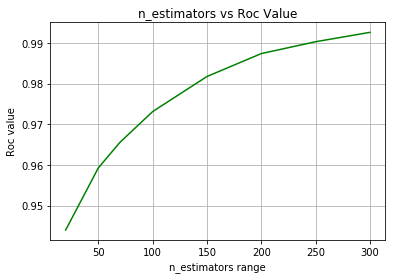

In [23]:
import matplotlib.pyplot as plt
nums = [10,30,50,70,100,120]
roc = []
for n in nums:
    gradient_boosting_classifier = ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,
      max_depth=n, max_leaf_nodes=15, random_state=0)
#    gradient_boosting_classifier = ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,
#     max_depth=50, max_leaf_nodes=15, random_state=0)
    gradient_boosting_classifier.fit(x_data, y_data)

    gradient_boosting_classifier_roc = metrics.roc_auc_score(
    y_data, gradient_boosting_classifier.predict_proba(x_data)[:,1])
    print(gradient_boosting_classifier_roc)
    roc.append(gradient_boosting_classifier_roc)
plt.plot(nums, roc,'g')
plt.xlabel('max_depth range')
plt.ylabel('Roc value')
plt.title('max_depth vs Roc Value')
#plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [27]:
classifier_list = [
    ("k_nearest_neighbor", knn_classifier, 3),
    ("random_forest", random_forest_classifier, 14),
    ("gradient_boosting", gradient_boosting_classifier, 9),
]

y_validation_hat_list = []
for classifier in classifier_list:
    y_validation_hat = classifier[1].predict_proba(x_data)[:,1]
    for i in range(classifier[2]):
        y_validation_hat_list.append(y_validation_hat)
        
y_validation_hat_average = np.mean(np.array(y_validation_hat_list), axis=0)

voting_roc = metrics.roc_auc_score(y_data, y_validation_hat_average)
print("roc:", voting_roc)
print("weight:", [classifier[2] for classifier in classifier_list])


roc: 0.9641600517682359
weight: [3, 14, 9]


In [0]:
y_test_hat_list = []
for classifier in classifier_list:
    y_test_hat = classifier[1].predict_proba(x_test)[:,1]
    for i in range(classifier[2]):
        y_test_hat_list.append(y_test_hat)
        
y_test_hat_average = np.mean(np.array(y_test_hat_list), axis=0)


In [0]:
to_kaggle(y_test_hat_average)
# .9641
# Kaggle score - 0.91800
# 3, 14, 9 weights

In [0]:
to_kaggle(y_test_hat_average)
# .9648
# Kaggle score - 0.91756
# 2, 15, 15 weights

In [0]:
to_kaggle(y_test_hat_average)
# .9641
# Kaggle score - 0.91800
# 3, 14, 9 weights

In [0]:
#using XGB

In [0]:
import xgboost as xgb

In [15]:
knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=20,metric= 'manhattan',weights='uniform', n_jobs=-1)

knn_classifier.fit(x_data, y_data)

y_validation_hat = knn_classifier.predict_proba(x_data)[:,1]

knn_classifier_roc = metrics.roc_auc_score(y_data, y_validation_hat)
print(knn_classifier_roc)

0.9266722432241473


In [16]:
params = {'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100,
 'oob_score': True
}
random_forest_classifier = ensemble.RandomForestClassifier(**params)

random_forest_classifier.fit(x_data, y_data)

random_forest_classifier_roc = metrics.roc_auc_score(
    y_data, random_forest_classifier.predict_proba(x_data)[:,1])
print(random_forest_classifier_roc)


0.958895283776057


In [19]:
params = {
    'colsample_bytree' : 0.7,
  'learning_rate' : 0.05,
  'min_child_weight' : 11,
  'missing': -999,
  'n_estimators': 100,
  'objective': 'binary:logistic',
  'seed': 7,
  'silent': 1,
  'subsample': 0.8
}
xgb_model = xgb.XGBClassifier(**params)
xgradient_boosting_classifier = []
xgradient_boosting_classifier.append(('standardize', preprocessing.StandardScaler()))
xgradient_boosting_classifier.append(('xgb', xgb_model))
xgradient_boosting_classifier = pipeline.Pipeline(xgradient_boosting_classifier)
xgradient_boosting_classifier.fit(x_data,y_data)

xgradient_boosting_classifier_roc = metrics.roc_auc_score(
   y_data, xgradient_boosting_classifier.predict_proba(x_data)[:,1])
print(xgradient_boosting_classifier_roc)

0.9143064614489239


In [31]:
classifier_list = [
#    ("k_nearest_neighbor", knn_classifier, 3),
    ("random_forest", random_forest_classifier, 20),
    ("gradient_boosting", xgradient_boosting_classifier, 5),
]

y_validation_hat_list = []
for classifier in classifier_list:
    y_validation_hat = classifier[1].predict_proba(x_data)[:,1]
    for i in range(classifier[2]):
        y_validation_hat_list.append(y_validation_hat)
        
y_validation_hat_average = np.mean(np.array(y_validation_hat_list), axis=0)

voting_roc = metrics.roc_auc_score(y_data, y_validation_hat_average)
print("roc:", voting_roc)
print("weight:", [classifier[2] for classifier in classifier_list])


roc: 0.9534637974740089
weight: [20, 5]


In [0]:
y_test_hat_list = []
for classifier in classifier_list:
    y_test_hat = classifier[1].predict_proba(x_test)[:,1]
    for i in range(classifier[2]):
        y_test_hat_list.append(y_test_hat)
        
y_test_hat_average = np.mean(np.array(y_test_hat_list), axis=0)


In [0]:
to_kaggle(y_test_hat_average)
# 0.9481
# Kaggle score - 0.91514
# 3, 14, 9 weights

In [0]:
# 0.9534
# Kaggle - 0.91238
# 20,5

In [0]:
parameters = {
              'xgb__nthread':[64], #when use hyperthread, xgboost may become slower
              'xgb__objective':['binary:logistic'],
              'xgb__learning_rate': [0.01, 0.02, 0.05], #so called `eta` value
              'xgb__max_depth': [10,15, 20, 30, 50,100, 500],
              'xgb__min_child_weight': [11],
              'xgb__silent': [1],
              'xgb__subsample': [0.8],
              'xgb__colsample_bytree': [0.7],
              'xgb__n_estimators': [30,50,100], #number of trees, change it to 1000 for better results
              'xgb__missing':[-999],
              'xgb__seed': [seed]}


clf = model_selection.GridSearchCV(model__, parameters, 
                   cv=10, 
                   scoring='roc_auc',
                   verbose=2)

In [0]:
#clf.fit(x_data,y_data)

In [41]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print(':', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

: 0.9223899439273129
xgb__colsample_bytree: 0.7
xgb__learning_rate: 0.05
xgb__max_depth: 10
xgb__min_child_weight: 11
xgb__missing: -999
xgb__n_estimators: 100
xgb__nthread: 64
xgb__objective: 'binary:logistic'
xgb__seed: None
xgb__silent: 1
xgb__subsample: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
